# Synthetic DataContainers from Composite Volume

This notebook builds a mumott `DataContainer` whose ground-truth reconstruction is derived from
`data/composite.npy` (a 100×100×100 scalar field) by assigning spherical-harmonic (SH) coefficient
vectors — extracted from an existing reconstruction — to every voxel based on which intensity bin
that voxel falls into.

**Pipeline**

1. Load and normalise `composite.npy` → `[0, 1]`
2. Pick *k* seed voxels from `results['x']` (indices supplied by the user)
3. Bin the volume into *k* equal-width bins; map each voxel to its bin's coefficient vector
4. Forward-project the resulting `(100, 100, 100, 45)` volume over 500 Fibonacci-hemisphere directions
5. Wrap everything in a `DataContainer` and save to `/myhome/data/smartt/shared/synthetic/`

## 1 · Imports and Setup

In [1]:
import sys, os
sys.path.insert(0, '/myhome/smartt')

import numpy as np
import matplotlib.pyplot as plt

from mumott.data_handling import DataContainer
from mumott.methods.basis_sets import SphericalHarmonics
from mumott.methods.projectors import SAXSProjector

from mumott_al import (
    fibonacci_hemisphere,
    cartesian_to_spherical,
    create_geometry_from_directions,
    generate_geometry_and_projections,
    create_synthetic_data_container,
)
from mumott_al.visualization import plot_projection_directions

print("Imports OK")

# ── Output directory ──────────────────────────────────────────────────────────
SAVE_DIR = '/myhome/data/smartt/shared/synthetic'
os.makedirs(SAVE_DIR, exist_ok=True)
SAVE_PATH = os.path.join(SAVE_DIR, 'dataset_composite_synthetic.h5')
print(f"Save path: {SAVE_PATH}")

INFO:Setting the number of threads to 8. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.
Imports OK
Save path: /myhome/data/smartt/shared/synthetic/dataset_composite_synthetic.h5


In [2]:
# ── Load reference DataContainer and reconstruction results ───────────────────
# The reference DataContainer is needed to borrow detector geometry metadata
# (detector_angles, two_theta, projection_shape, …).
# The reconstruction results['x'] (shape: X×Y×Z×45) provides the SH coefficient
# library from which the k seed voxels are drawn.

DATA_PATH = '/myhome/data/smartt/shared/b411/dataset_b411R_inf_1_0.220_1.900.h5'
dc = DataContainer(DATA_PATH)
print(f"Reference DataContainer loaded: {dc.data.shape}")

CACHE_DIR = os.path.join(os.path.dirname(DATA_PATH), 'recon_cache')
_cache = os.path.join(CACHE_DIR, 'results.npz')
results = {k: v for k, v in np.load(_cache).items()}
print(f"results['x'] shape : {results['x'].shape}")   # (X, Y, Z, 45)

INFO:Rotation matrices were loaded from the input file.
INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.
Reference DataContainer loaded: (266, 111, 86, 8)
results['x'] shape : (86, 111, 86, 45)


## 2 · Load and Normalise Composite Volume

Composite volume shape : (100, 100, 100)
Value range before normalisation: [29334.0000, 36796.0000]
Value range after  normalisation: [0.0000, 1.0000]


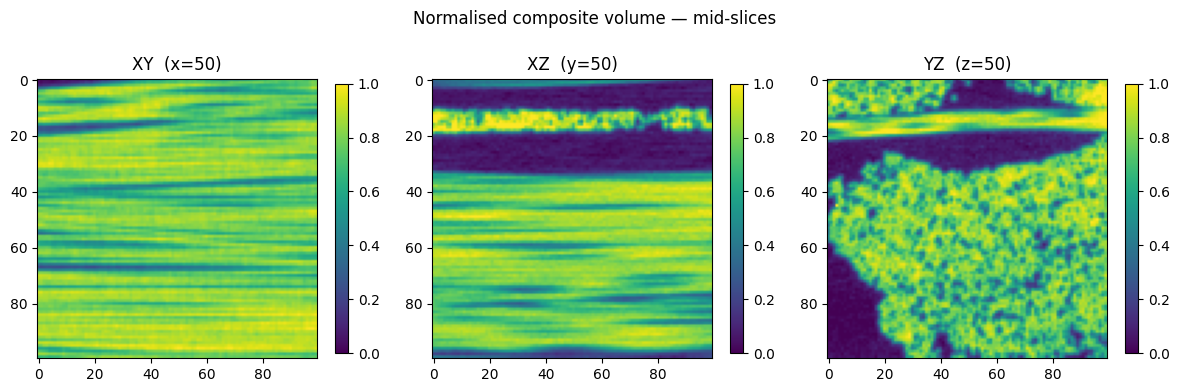

In [3]:
COMPOSITE_PATH = os.path.join(os.path.dirname(os.path.dirname(DATA_PATH)),
                               '..', '..', 'smartt', 'data', 'composite.npy')
# Alternatively, use the absolute path directly:
COMPOSITE_PATH = '/myhome/smartt/data/composite.npy'

volume = np.load(COMPOSITE_PATH)
print(f"Composite volume shape : {volume.shape}")   # expected (100, 100, 100)
print(f"Value range before normalisation: [{volume.min():.4f}, {volume.max():.4f}]")

# Min-max normalise to [0, 1]
vol_min, vol_max = volume.min(), volume.max()
volume_norm = (volume - vol_min) / (vol_max - vol_min)
print(f"Value range after  normalisation: [{volume_norm.min():.4f}, {volume_norm.max():.4f}]")

# Quick visual: three orthogonal mid-slices
mid = np.array(volume_norm.shape) // 2
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, (sl, title) in zip(axes, [
    (volume_norm[mid[0], :, :], f'XY  (x={mid[0]})'),
    (volume_norm[:, mid[1], :], f'XZ  (y={mid[1]})'),
    (volume_norm[:, :, mid[2]], f'YZ  (z={mid[2]})'),
]):
    im = ax.imshow(sl, cmap='viridis', vmin=0, vmax=1)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, shrink=0.8)
plt.suptitle('Normalised composite volume — mid-slices', fontsize=12)
plt.tight_layout()
plt.show()

## 3 · Binning Scheme and SH Coefficient Assignment

For each of the *k* bins we pick one representative voxel (identified by its `(i, j, k)` index in `results['x']`).
Every voxel in the 100³ composite volume is then assigned the SH coefficient vector of the bin it falls into.

In [4]:
def build_ground_truth(
    volume_norm: np.ndarray,
    voxel_indices: list,
    results_x: np.ndarray,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Construct a (100, 100, 100, 45) ground-truth tensor by:

    1. Extracting *k* SH coefficient vectors from *results_x* at *voxel_indices*.
    2. Dividing [0, 1] into *k* equal-width bins.
    3. Assigning each voxel of *volume_norm* the coefficient vector of the bin it falls into.

    Parameters
    ----------
    volume_norm : ndarray, shape (100, 100, 100)
        Volume normalised to [0, 1].
    voxel_indices : list of (int, int, int)
        *k* voxel coordinates (i, j, k) into *results_x*.  The number of
        entries determines the number of bins *k*.
    results_x : ndarray, shape (X, Y, Z, 45)
        Full SH reconstruction from which seed voxels are drawn.

    Returns
    -------
    ground_truth : ndarray, shape (100, 100, 100, 45)
    sh_coeffs    : ndarray, shape (k, 45)   – the k representative coefficient vectors
    bin_indices  : ndarray, shape (100, 100, 100) – integer bin assignment (0 … k-1)
    """
    voxel_indices = list(voxel_indices)
    k = len(voxel_indices)
    n_coeffs = results_x.shape[-1]   # 45 for ell_max=8

    # ── 1. Extract k SH coefficient vectors ──────────────────────────────────
    sh_coeffs = np.stack(
        [results_x[i, j, l, :] for (i, j, l) in voxel_indices],
        axis=0,
    )  # shape: (k, 45)
    print(f"Extracted {k} seed voxels → sh_coeffs shape: {sh_coeffs.shape}")

    # ── 2. Create k equal-width bins over [0, 1] ─────────────────────────────
    # np.linspace gives k+1 edges → k bins
    bin_edges = np.linspace(0.0, 1.0, k + 1)
    print(f"Bin edges: {np.round(bin_edges, 4)}")

    # np.digitize returns values in 1..k; clip to 0..k-1 for array indexing
    raw_bins   = np.digitize(volume_norm, bins=bin_edges[1:-1])  # 0..k-1
    bin_indices = np.clip(raw_bins, 0, k - 1).astype(np.int32)
    print(f"Bin index range: [{bin_indices.min()}, {bin_indices.max()}]")
    unique, counts = np.unique(bin_indices, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"  Bin {u}: {c:,} voxels  ({100*c/bin_indices.size:.1f} %)")

    # ── 3. Assign coefficient vector to every voxel ───────────────────────────
    ground_truth = sh_coeffs[bin_indices]   # shape: (100, 100, 100, 45)
    print(f"\nGround-truth tensor shape: {ground_truth.shape}")
    return ground_truth, sh_coeffs, bin_indices

## 4 · Build and Visualise the Ground-Truth Tensor

Edit `VOXEL_INDICES` to choose which voxels from `results['x']` act as the *k* prototypes.
The number of entries in `VOXEL_INDICES` automatically sets *k* (= number of bins).

In [19]:
VOXEL_INDICES

[(24, 55, 43),
 (32, 77, 43),
 (48, 44, 43),
 (56, 66, 43),
 (64, 88, 43),
 (72, 99, 43),
 (43, 55, 43)]

In [24]:
top_coords

(array([50, 45, 45, 44, 49, 49, 50, 47, 50, 49, 46, 51, 44, 49, 43, 45, 45,
        46, 44, 48]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([50, 51, 52, 51, 48, 50, 49, 52, 51, 52, 51, 51, 50, 49, 50, 53, 50,
        53, 52, 52]))

In [30]:
anisotropy.flatten().shape

(820956,)

In [40]:
# ── Select the top-20 most anisotropic voxels from results['x'] ──────────────
# Anisotropy = sum of squared SH coefficients for ℓ > 0  (i.e. all but coeff 0)
X, Y, Z = results['x'].shape[:3]

VOXEL_INDICES = [
    (36, 5, 54),
    (36, 4, 49),
    (56, 32, 0),
    (50, 0, 50),
    (60, 16, 19),
    (14, 0, 39)
]

print(f"k = {len(VOXEL_INDICES)} seed voxels → {len(VOXEL_INDICES)} bins")
print(f"{'Rank':<6} {'(i, j, k)':<20} {'Anisotropy':>14}")
print("-" * 42)
for rank, (i, j, k) in enumerate(VOXEL_INDICES):
    print(f"{rank:<6} ({i:3d},{j:3d},{k:3d})   {anisotropy[i, j, k]:>14.6f}")

ground_truth, sh_coeffs, bin_indices = build_ground_truth(
    volume_norm=volume_norm,
    voxel_indices=VOXEL_INDICES,
    results_x=results['x'],
)

k = 6 seed voxels → 6 bins
Rank   (i, j, k)                Anisotropy
------------------------------------------
0      ( 36,  5, 54)   1984679.741474
1      ( 36,  4, 49)   1619871.617566
2      ( 56, 32,  0)   1456768.321922
3      ( 50,  0, 50)   16177498.040989
4      ( 60, 16, 19)   1157009.579857
5      ( 14,  0, 39)   4971530.411078
Extracted 6 seed voxels → sh_coeffs shape: (6, 45)
Bin edges: [0.     0.1667 0.3333 0.5    0.6667 0.8333 1.    ]
Bin index range: [0, 5]
  Bin 0: 190,302 voxels  (19.0 %)
  Bin 1: 46,309 voxels  (4.6 %)
  Bin 2: 71,207 voxels  (7.1 %)
  Bin 3: 148,387 voxels  (14.8 %)
  Bin 4: 335,589 voxels  (33.6 %)
  Bin 5: 208,206 voxels  (20.8 %)

Ground-truth tensor shape: (100, 100, 100, 45)


### Visualise the *k* seed voxels (SH functions)

Each plot shows the pole figure and 3-D scattering pattern of the SH coefficient vector
assigned to one bin.  The bin ordering matches the intensity range: bin 0 → darkest voxels,
bin *k−1* → brightest voxels.

Visualising 6 seed voxel(s) …


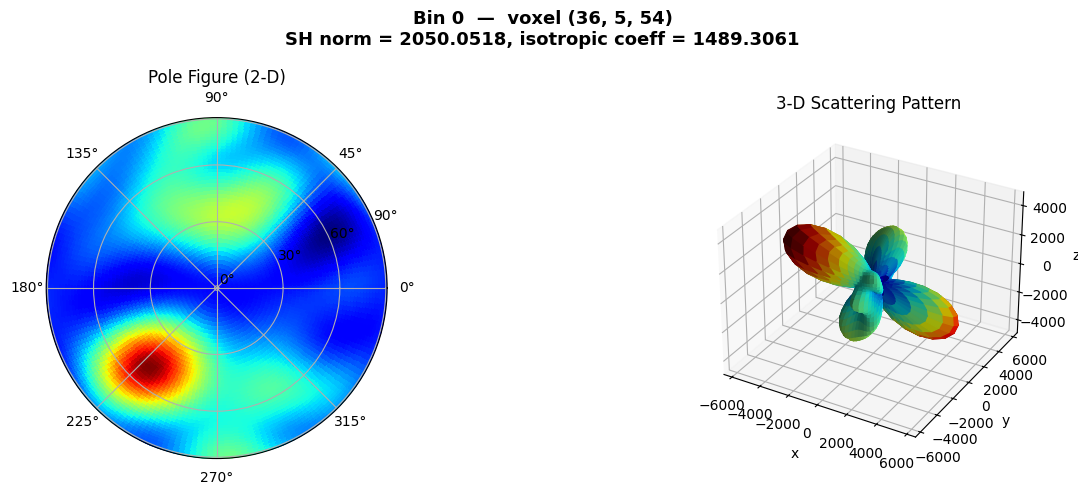

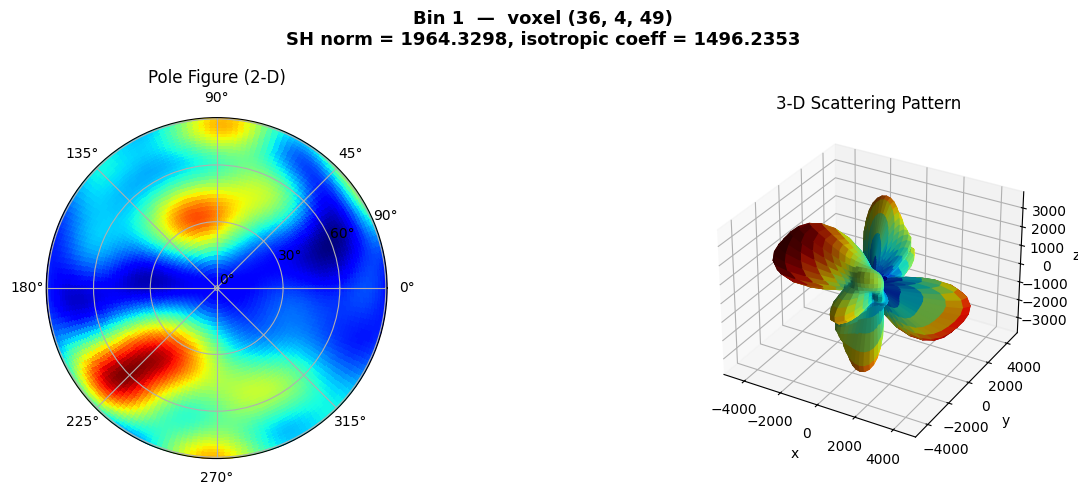

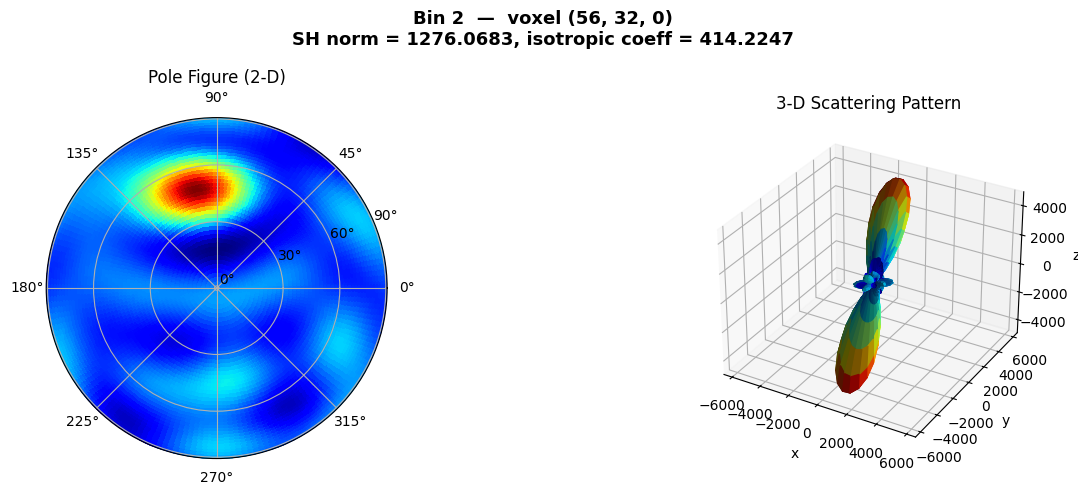

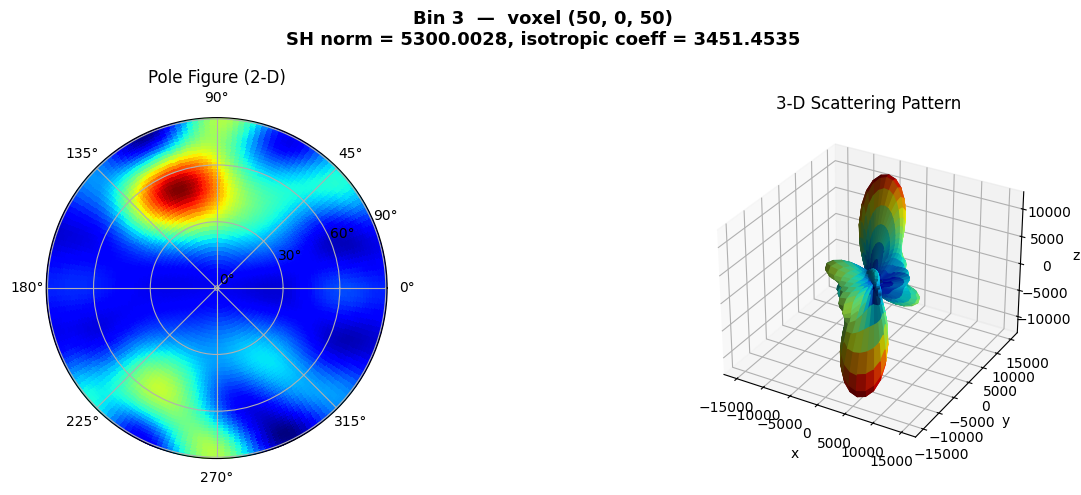

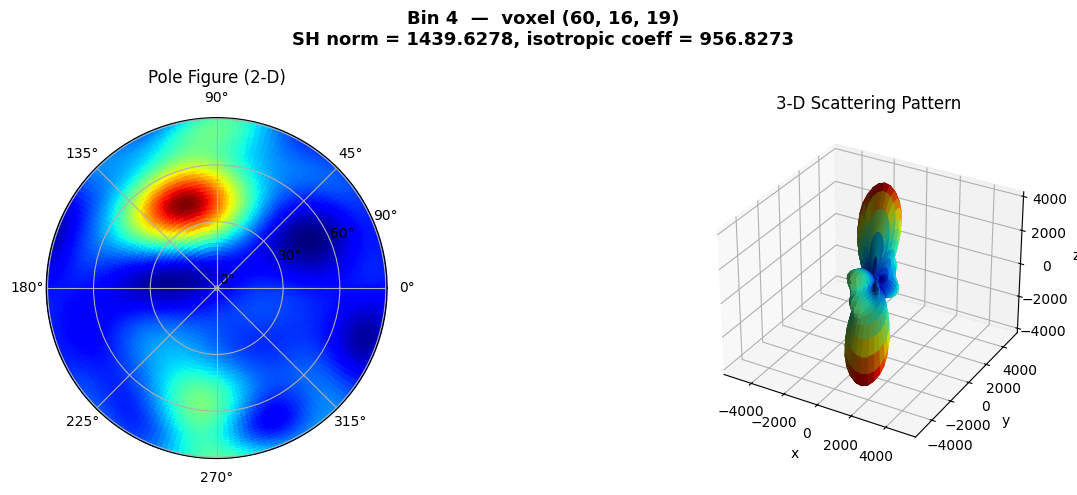

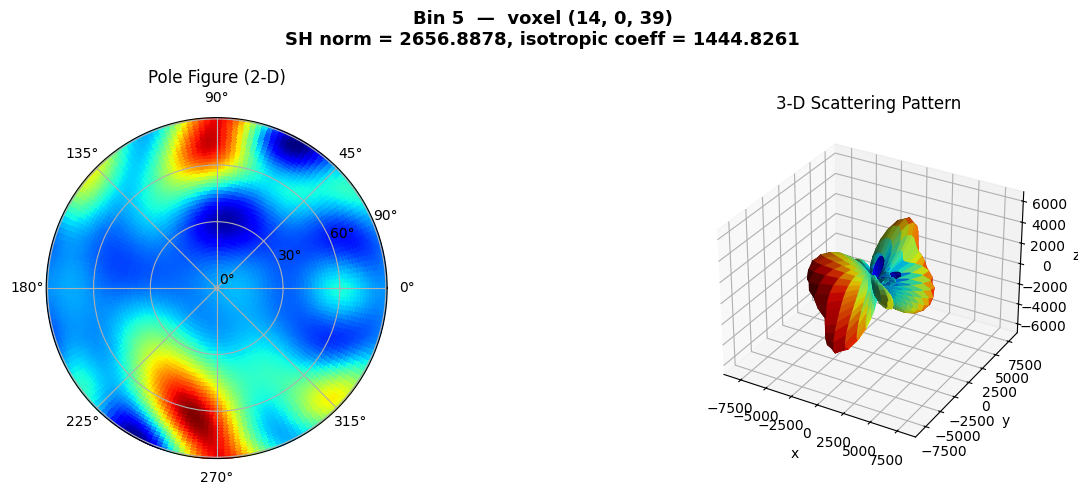

In [41]:
import importlib
import mumott_al.visualization
importlib.reload(mumott_al.visualization)
from mumott_al.visualization import visualize_seed_voxels

visualize_seed_voxels(
    voxel_indices=VOXEL_INDICES,
    results_x=results['x'],
    ell_max=8,
)

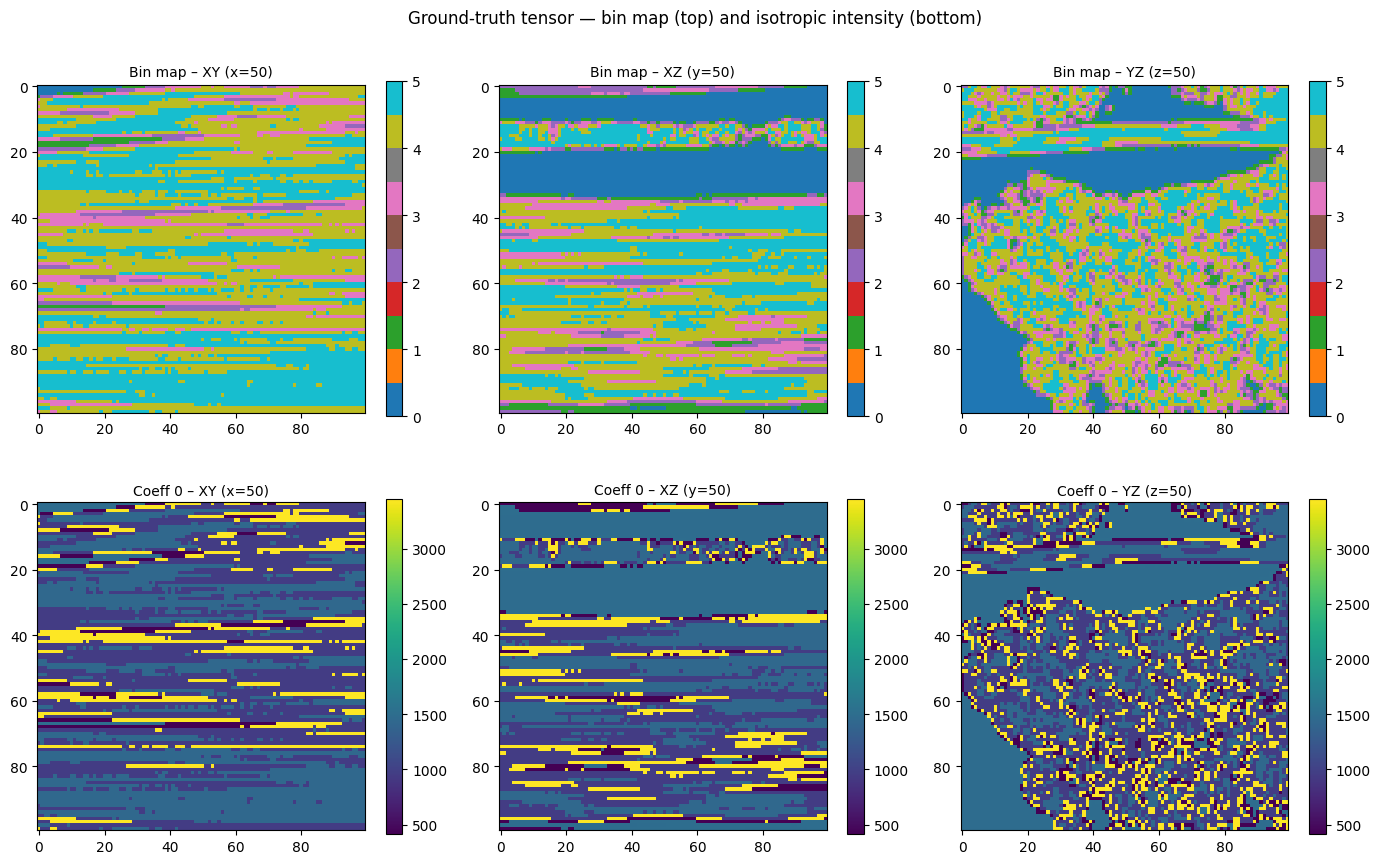


Ground-truth shape : (100, 100, 100, 45)
dtype              : float64
Value range        : [-2198.1406, 3451.4535]


In [42]:
# Visualise the bin-index map and the first SH coefficient (intensity proxy)
mid = np.array(ground_truth.shape[:3]) // 2

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
slices = [
    (bin_indices[mid[0], :, :],      f'Bin map – XY (x={mid[0]})'),
    (bin_indices[:, mid[1], :],      f'Bin map – XZ (y={mid[1]})'),
    (bin_indices[:, :, mid[2]],      f'Bin map – YZ (z={mid[2]})'),
    (ground_truth[mid[0], :, :, 0],  f'Coeff 0 – XY (x={mid[0]})'),
    (ground_truth[:, mid[1], :, 0],  f'Coeff 0 – XZ (y={mid[1]})'),
    (ground_truth[:, :, mid[2], 0],  f'Coeff 0 – YZ (z={mid[2]})'),
]
cmaps = ['tab10'] * 3 + ['viridis'] * 3

for ax, (data, title), cmap in zip(axes.flat, slices, cmaps):
    im = ax.imshow(data, cmap=cmap)
    ax.set_title(title, fontsize=10)
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle('Ground-truth tensor — bin map (top) and isotropic intensity (bottom)', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nGround-truth shape : {ground_truth.shape}")
print(f"dtype              : {ground_truth.dtype}")
print(f"Value range        : [{ground_truth.min():.4f}, {ground_truth.max():.4f}]")

## 5 · Generate Fibonacci-Hemisphere Geometry (500 directions)

Generated 500 directions, shape: (500, 3)
inner_angle range: [-179.4°, 179.9°]
outer_angle range: [10.0°, 90.0°]

First 5 directions (x, y, z):
[[ 1.          0.          0.        ]
 [-0.73736744  0.67548898  0.00197356]
 [ 0.08742504 -0.99616328  0.00394713]
 [ 0.6084282   0.79358684  0.00592069]
 [-0.9846828  -0.17417652  0.00789425]]

New geometry: 500 projections


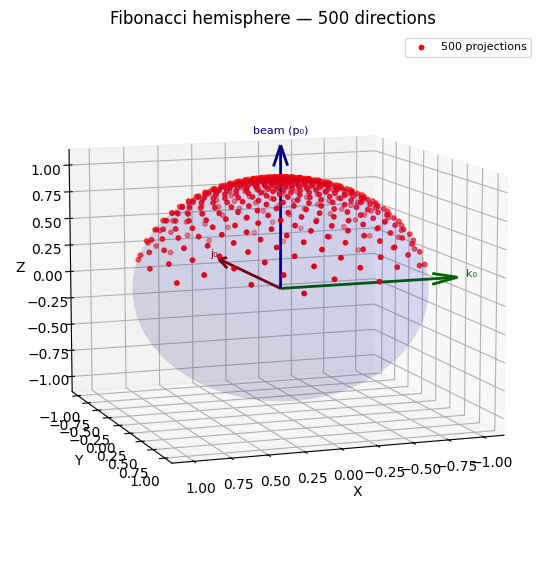

In [ ]:
N_FIBONACCI = 500

# Generate 500 evenly distributed directions on the upper hemisphere
directions = fibonacci_hemisphere(N_FIBONACCI, upper=True, missing_wedge_angle=45)
print(f"Generated {len(directions)} directions, shape: {directions.shape}")

# Convert to spherical coordinates for inspection
inner_angles, outer_angles = cartesian_to_spherical(directions)
print(f"inner_angle range: [{np.degrees(inner_angles.min()):.1f}°, {np.degrees(inner_angles.max()):.1f}°]")
print(f"outer_angle range: [{np.degrees(outer_angles.min()):.1f}°, {np.degrees(outer_angles.max()):.1f}°]")
print(f"\nFirst 5 directions (x, y, z):")
print(directions[:5])

# Create the geometry from these directions, borrowing metadata from dc
new_geometry = create_geometry_from_directions(
    directions=directions,
    reference_geometry=dc.geometry,
)
print(f"\nNew geometry: {len(new_geometry.inner_angles)} projections")

# Visualise
fig, ax = plot_projection_directions(new_geometry)
ax.set_title(f'Fibonacci hemisphere — {N_FIBONACCI} directions')
plt.show()

## 6 · Compute Forward Projections

Forward-project the `(100, 100, 100, 45)` ground-truth through the 500 Fibonacci directions
using `SAXSProjector` and `SphericalHarmonics`.

In [ ]:
ELL_MAX = 8

# Build projector and basis set for the new geometry
projector  = SAXSProjector(new_geometry)
basis_set  = SphericalHarmonics(
    ell_max=ELL_MAX,
    probed_coordinates=new_geometry.probed_coordinates,
)

print("Running forward projection …")
# ground_truth must be float64 for mumott projectors
gt_f64 = ground_truth.astype(np.float64)
radon_stack = projector.forward(gt_f64)          # shape: (500, J, K, n_basis)
synthetic_projections = basis_set.forward(radon_stack)  # shape: (500, J, K, n_channels)

print(f"Radon stack shape         : {radon_stack.shape}")
print(f"Synthetic projections shape: {synthetic_projections.shape}")
print(f"  (n_proj={synthetic_projections.shape[0]}, "
      f"det_j={synthetic_projections.shape[1]}, "
      f"det_k={synthetic_projections.shape[2]}, "
      f"n_channels={synthetic_projections.shape[3]})")

# Quick visualisation of a few projections
n_show = min(4, N_FIBONACCI)
fig, axes = plt.subplots(2, n_show, figsize=(4 * n_show, 8))
for i in range(n_show):
    axes[0, i].imshow(synthetic_projections[i].sum(axis=-1), cmap='viridis')
    axes[0, i].set_title(f'Proj {i} — sum over channels\n'
                         f'inner={np.degrees(new_geometry.inner_angles[i]):.1f}°')
    axes[1, i].imshow(synthetic_projections[i, :, :, 0], cmap='viridis')
    axes[1, i].set_title(f'Channel 0')
plt.suptitle('Synthetic forward projections (ground-truth volume)', fontsize=12)
plt.tight_layout()
plt.show()

## 7 · Create and Save the DataContainer

`generate_geometry_and_projections` (with `return_data_container=True`) packages the forward
projections into a `ProjectionStack`, which `create_synthetic_data_container` then wraps in a
full-featured `DataContainer` and saves to disk.

In [ ]:
# generate_geometry_and_projections returns a (Geometry, ProjectionStack) pair
# when return_data_container=True.  We already have `new_geometry` and
# `synthetic_projections` from the previous cell, so we call
# generate_geometry_and_projections here to get the ProjectionStack wrapper.
_, projection_stack = generate_geometry_and_projections(
    reconstruction=ground_truth,
    directions=directions,
    reference_geometry=dc.geometry,
    ell_max=ELL_MAX,
    return_data_container=True,   # ← returns ProjectionStack, not raw ndarray
)
print(f"ProjectionStack: {len(projection_stack)} projections")
print(f"Data shape      : {projection_stack.data.shape}")

In [ ]:
# Build and persist the DataContainer
composite_dc = create_synthetic_data_container(
    geometry=new_geometry,
    projection_stack=projection_stack,
    reference_dc=dc,                # borrows detector metadata from the real dataset
    save_path=SAVE_PATH,            # saves to /myhome/data/smartt/shared/synthetic/
)

print(f"\nDataContainer created and saved to:\n  {SAVE_PATH}")
print(f"  Projections : {len(composite_dc.projections)}")
print(f"  Data shape  : {composite_dc.data.shape}")
print(f"  Geometry    : {len(composite_dc.geometry.inner_angles)} projection angles")

In [ ]:
# ── Reload from disk to verify integrity ─────────────────────────────────────
dc_verify = DataContainer(SAVE_PATH)
print("Reloaded DataContainer from disk:")
print(f"  Data shape  : {dc_verify.data.shape}")
print(f"  Projections : {len(dc_verify.projections)}")
print(f"  inner_angles: {len(dc_verify.geometry.inner_angles)}")
print(f"  outer_angles: {len(dc_verify.geometry.outer_angles)}")

# Spot-check: compare a projection from the in-memory and reloaded containers
diff = np.max(np.abs(composite_dc.data - dc_verify.data))
print(f"\nMax data difference (in-memory vs reloaded): {diff:.2e}  (should be 0 or tiny)")

print("\nSummary")
print(f"  Composite volume path  : {COMPOSITE_PATH}")
print(f"  k bins / seed voxels   : {len(VOXEL_INDICES)}")
print(f"  Ground-truth shape     : {ground_truth.shape}")
print(f"  Projection directions  : {N_FIBONACCI}")
print(f"  Saved DataContainer    : {SAVE_PATH}")

---
## All-in-one convenience wrapper

The cell below bundles the entire pipeline into a single function for reuse.

In [ ]:
def create_composite_synthetic_dc(
    voxel_indices: list,
    results_x: np.ndarray,
    reference_dc: DataContainer,
    composite_path: str = '/myhome/smartt/data/composite.npy',
    n_fibonacci: int = 500,
    ell_max: int = 8,
    save_path: str = '/myhome/data/smartt/shared/synthetic/dataset_composite_synthetic.h5',
    missing_wedge_angle: float = 45.0,
) -> DataContainer:
    """
    Full pipeline: composite volume  →  binned SH ground truth  →  forward projections  →  DataContainer.

    Parameters
    ----------
    voxel_indices : list of (int, int, int)
        *k* voxel coordinates (i, j, l) into *results_x*.
        Determines both the number of bins and the SH prototype for each bin.
    results_x : ndarray, shape (X, Y, Z, 45)
        Reconstruction whose voxels serve as SH prototypes.
    reference_dc : DataContainer
        Reference dataset; its geometry metadata (detector angles, two_theta, …)
        is copied into the new DataContainer.
    composite_path : str
        Path to the 100×100×100 `.npy` volume.
    n_fibonacci : int
        Number of Fibonacci-hemisphere projection directions.
    ell_max : int
        Maximum SH order (must match the number of coefficients in results_x).
    save_path : str
        HDF5 output path (will be created; parent directory must exist).
    missing_wedge_angle : float
        Half-opening angle (degrees) of the missing wedge; passed to
        ``fibonacci_hemisphere``.

    Returns
    -------
    DataContainer
        The newly created DataContainer (also saved to *save_path*).
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # 1. Load and normalise
    volume      = np.load(composite_path)
    vol_min, vol_max = volume.min(), volume.max()
    volume_norm = (volume - vol_min) / (vol_max - vol_min)
    print(f"[1] Loaded composite: {volume.shape}, normalised to [{volume_norm.min():.3f}, {volume_norm.max():.3f}]")

    # 2. Build ground-truth tensor
    gt, sh_coeffs, bin_idx = build_ground_truth(volume_norm, voxel_indices, results_x)
    print(f"[2] Ground-truth shape: {gt.shape}")

    # 3. Fibonacci hemisphere geometry
    directions   = fibonacci_hemisphere(n_fibonacci, upper=True, missing_wedge_angle=missing_wedge_angle)
    new_geometry = create_geometry_from_directions(directions, reference_dc.geometry)
    print(f"[3] Geometry: {len(new_geometry.inner_angles)} directions")

    # 4. Forward projections + ProjectionStack
    _, proj_stack = generate_geometry_and_projections(
        reconstruction=gt,
        directions=directions,
        reference_geometry=reference_dc.geometry,
        ell_max=ell_max,
        return_data_container=True,
    )
    print(f"[4] Projection stack: {proj_stack.data.shape}")

    # 5. Create and save DataContainer
    new_dc = create_synthetic_data_container(
        geometry=new_geometry,
        projection_stack=proj_stack,
        reference_dc=reference_dc,
        save_path=save_path,
    )
    print(f"[5] DataContainer saved to: {save_path}")
    return new_dc


# ── Quick demo ────────────────────────────────────────────────────────────────
if __name__ == '__main__' or True:
    demo_dc = create_composite_synthetic_dc(
        voxel_indices=VOXEL_INDICES,
        results_x=results['x'],
        reference_dc=dc,
        composite_path='/myhome/smartt/data/composite.npy',
        n_fibonacci=500,
        ell_max=8,
        save_path=SAVE_PATH,
    )
    print(f"\nFinal DataContainer — projections: {len(demo_dc.projections)}, data: {demo_dc.data.shape}")